---
title: "Project Working File"
execute:
  kernel: ad688-venv
bibliography: references.bib
csl: csl/econometrica.csl
format: 
  html:
    toc: true
    number-sections: true
    df-print: paged
---

## This file contains the code blocks for data cleaning, EDAs, skill gap analysis, NLP processing, etc. as a working file
## Each file that contributes to the overall quarto website will contain the text and visual outputs only. 


### Code block for data_cleaning.qmd: 

In [ ]:
# ADDING IN MORE LIBRARIES
# -------------------------------------------------------------------
# Global Plotly Styling — applies to all visualizations in this report
# -------------------------------------------------------------------
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

# pio.templates.default = "plotly_white"
# pio.templates["plotly_white"].layout.font.family = "Arial"
# pio.templates["plotly_white"].layout.font.size = 14
# pio.templates["plotly_white"].layout.title.font.size = 18

custom_theme = go.layout.Template(
    layout=go.Layout(
        font=dict(family="Arial", size=12, color="#000000"),
        title=dict(font=dict(size=16, family="Arial", color="#000000")),
        paper_bgcolor="white",
        plot_bgcolor="white",
        colorway=px.colors.qualitative.Set2,
        xaxis=dict(
            showgrid=False,
            gridcolor="#c0c0c0",  # same as Matplotlib grid
            zeroline=False,
            linecolor="black",
            mirror=True,
            ticks="outside",
            title_font=dict(size=13, family="Arial"),
            tickfont=dict(size=11, family="Arial")
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor="#c0c0c0",
            zeroline=False,
            linecolor="black",
            mirror=True,
            ticks="outside",
            title_font=dict(size=13, family="Arial"),
            tickfont=dict(size=11, family="Arial")
        )
    )
)

pio.templates["custom_white"] = custom_theme
pio.templates.default = "custom_white"

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid") 
plt.rcParams.update({
    "font.family": "Arial",
    "font.size": 7,
    "axes.titlesize": 11,
    "axes.labelsize": 9,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "figure.dpi": 120,
    "savefig.dpi": 150,
    "axes.grid": True,
    "grid.color": "#c0c0c0"
})
sns.set_palette("Set2")

In [183]:
import pandas as pd

# Load lightcast_job_postings.csv 
df = pd.read_csv("data/lightcast_job_postings.csv")

# Show the first 5 rows 
#print(df.head(5).to_string())

/var/folders/y1/rx8hx7116f35w_wcxbtlb5m80000gn/T/ipykernel_87598/2197761775.py:4: DtypeWarning:

Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
# Drop columns
columns_to_drop = [
    # Meta/tracking
    "ID", "LAST_UPDATED_DATE", "LAST_UPDATED_TIMESTAMP", "DUPLICATES", "URL",
    "ACTIVE_URLS", "ACTIVE_SOURCES_INFO", "SOURCE_TYPES", "SOURCES",

    # Duplicated location info
    "LOCATION", "CITY", "STATE", "COUNTY", "COUNTY_NAME",
    "COUNTY_OUTGOING", "COUNTY_NAME_OUTGOING", "COUNTY_INCOMING", "COUNTY_NAME_INCOMING",
    "MSA", "MSA_OUTGOING", "MSA_NAME_OUTGOING", "MSA_INCOMING", "MSA_NAME_INCOMING",

    # Raw/duplicate title & body
    "TITLE_RAW", "TITLE_NAME",

    # Duplicated employment info
    "EMPLOYMENT_TYPE", "EMPLOYMENT_TYPE_NAME",

    # Education code columns
    "EDUCATION_LEVELS", "EDUCATION_LEVELS_NAME", "MIN_EDULEVELS", "MAX_EDULEVELS",

    # Redundant NAICS/SOC versions
    "NAICS2", "NAICS2_NAME", "NAICS3", "NAICS3_NAME", "NAICS4", "NAICS4_NAME",
    "NAICS5", "NAICS5_NAME", "NAICS6", "NAICS6_NAME",
    "SOC_2", "SOC_2_NAME", "SOC_3", "SOC_3_NAME", "SOC_4", "SOC_4_NAME",
    "SOC_5",  # keep SOC_5_NAME, drop code
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME",
    "SOC_2021_4", "SOC_2021_4_NAME", "SOC_2021_5", "SOC_2021_5_NAME",

    # LOT/V6 occupation hierarchy (keep only 1 specialized name field)
    "LOT_CAREER_AREA", "LOT_CAREER_AREA_NAME", "LOT_OCCUPATION", "LOT_OCCUPATION_NAME",
    "LOT_OCCUPATION_GROUP", "LOT_OCCUPATION_GROUP_NAME",
    "LOT_V6_SPECIALIZED_OCCUPATION", "LOT_V6_SPECIALIZED_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION", "LOT_V6_OCCUPATION_NAME",
    "LOT_V6_OCCUPATION_GROUP", "LOT_V6_OCCUPATION_GROUP_NAME",
    "LOT_V6_CAREER_AREA", "LOT_V6_CAREER_AREA_NAME",

    # ONET & CIP codes 
    "ONET", "ONET_NAME", "ONET_2019", "ONET_2019_NAME",
    "CIP2", "CIP2_NAME", "CIP4", "CIP4_NAME", "CIP6", "CIP6_NAME",

    # Sectors
    "LIGHTCAST_SECTORS", "LIGHTCAST_SECTORS_NAME",

    # NAICS 2022 lower-level codes
    "NAICS_2022_2", "NAICS_2022_2_NAME", "NAICS_2022_3", "NAICS_2022_3_NAME",
    "NAICS_2022_4", "NAICS_2022_4_NAME", "NAICS_2022_5", "NAICS_2022_5_NAME",
    "NAICS_2022_6",  # drop code, keep name
]

df.drop(columns=columns_to_drop, inplace=True)
#df.info()

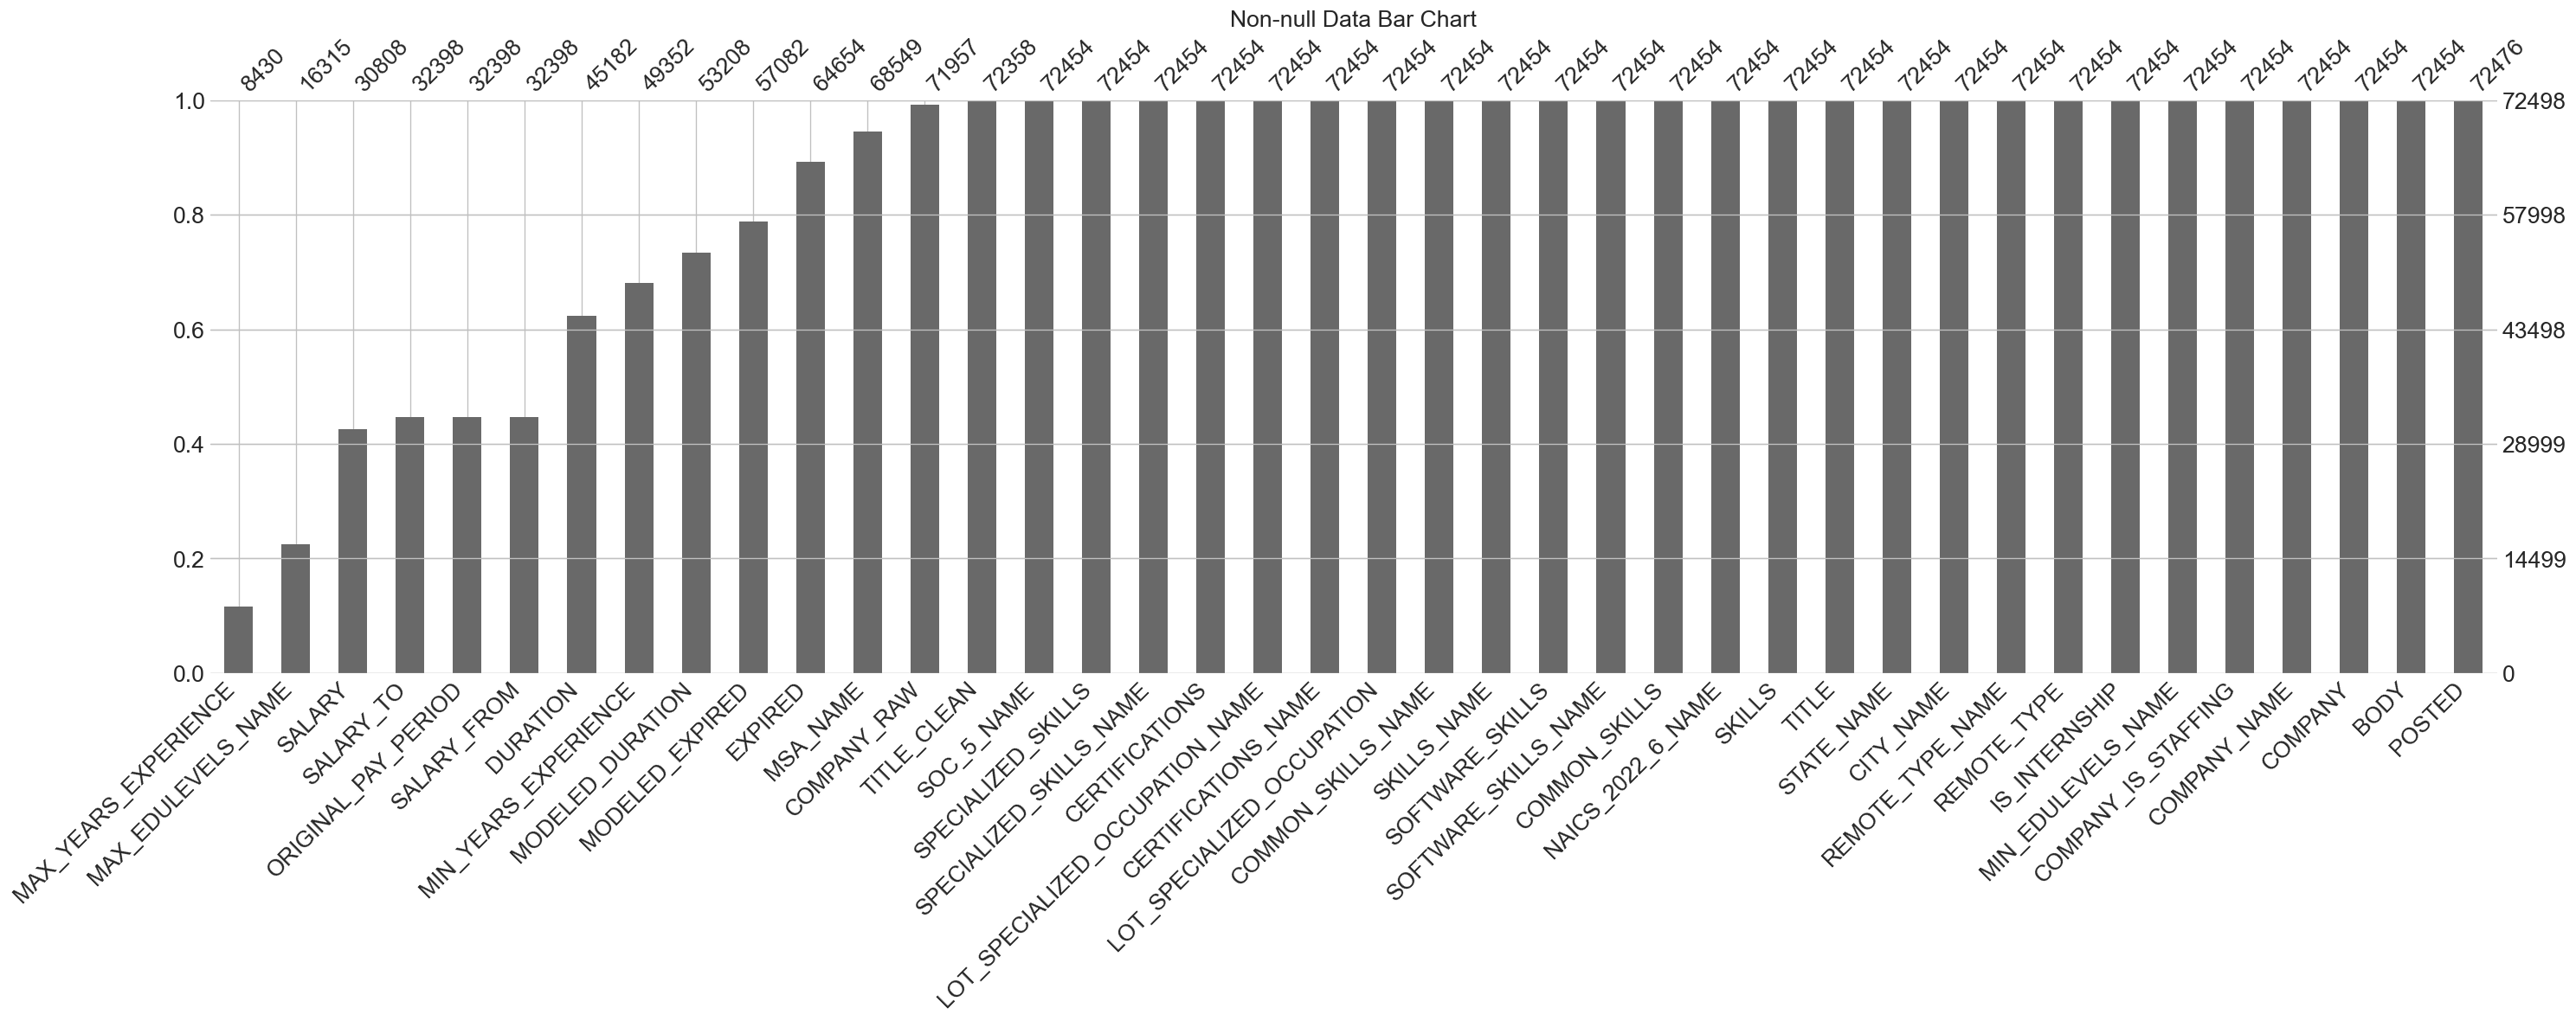

                         Column  Missing %
           MAX_YEARS_EXPERIENCE  88.372093
             MAX_EDULEVELS_NAME  77.495931
                         SALARY  57.505035
                      SALARY_TO  55.311871
            ORIGINAL_PAY_PERIOD  55.311871
                    SALARY_FROM  55.311871
                       DURATION  37.678281
           MIN_YEARS_EXPERIENCE  31.926398
               MODELED_DURATION  26.607631
                MODELED_EXPIRED  21.264035
                        EXPIRED  10.819609
                       MSA_NAME   5.447047
                    COMPANY_RAW   0.746227
                    TITLE_CLEAN   0.193109
                     SOC_5_NAME   0.060691
             SPECIALIZED_SKILLS   0.060691
        SPECIALIZED_SKILLS_NAME   0.060691
                 CERTIFICATIONS   0.060691
LOT_SPECIALIZED_OCCUPATION_NAME   0.060691
            CERTIFICATIONS_NAME   0.060691
     LOT_SPECIALIZED_OCCUPATION   0.060691
             COMMON_SKILLS_NAME   0.060691
           

In [185]:
import missingno as msno
import matplotlib.pyplot as plt

# Identify columns that have a significant amount of missing values and sort df by the percentage of missing values
missing_percent = df.isnull().mean().sort_values(ascending=False)*100
df_sorted = df[missing_percent.index]

# Visualize missing data using missingno bar chart 
plt.figure(figsize=(12, 6))
msno.bar(df_sorted)
plt.title("Non-null Data Bar Chart")
plt.tight_layout()
out_path = "figures/non-null_data.png"
plt.savefig(out_path, dpi=150)
plt.show()

missing_values_pct = (missing_percent.reset_index().rename(columns={"index": "Column", 0: "Missing %"}))
print(missing_values_pct.to_string(index=False))


In [186]:
# Drop columns with >50% missing values
cols_to_drop_missing = [
    "MAX_YEARS_EXPERIENCE",
    "MAX_EDULEVELS_NAME",
    "SALARY_FROM",
    "SALARY_TO",
    "ORIGINAL_PAY_PERIOD",
    "MODELED_DURATION",
    "MODELED_EXPIRED",
    "EXPIRED"
]
df.drop(columns=cols_to_drop_missing, inplace=True)

# Fill categorical columns with "Unknown"
fill_col_unk = [
    # Company info
    "COMPANY_NAME", "COMPANY_IS_STAFFING",
    
    # Job titles
    "TITLE", "TITLE_CLEAN",
    
    # Occupation/industry (kept name fields)
    "SOC_5_NAME", "LOT_SPECIALIZED_OCCUPATION_NAME", "NAICS_2022_6_NAME",
    
    # Remote type
    "REMOTE_TYPE_NAME",
    
    # Education level (names, not codes)
    "MIN_EDULEVELS_NAME", 
    
    # Location info
    "STATE_NAME", "CITY_NAME", "MSA_NAME",
    
    # Skills/certifications (optional — only if you plan to analyze skills)
    "SKILLS_NAME", "SPECIALIZED_SKILLS_NAME", "COMMON_SKILLS_NAME", "CERTIFICATIONS_NAME"
]

# Loop through and fill missing values
for col in fill_col_unk:
    df[col] = df[col].fillna("Unknown")

# Create a cleaned version for SALARY with median imputation
df["SALARY_CLEANED"] = df["SALARY"].copy()
median_salary = df["SALARY"].median()
df["SALARY_CLEANED"] = df["SALARY_CLEANED"].fillna(median_salary)

# Drop columns with >50% missing values
#df.info()

In [187]:
# Remove duplicate
df=df.drop_duplicates(subset=["TITLE_CLEAN", "COMPANY_NAME", "POSTED", "REMOTE_TYPE_NAME", "SKILLS_NAME"], keep="first")

# Preview new df
df.shape

(55656, 33)

### Code block for eda.qmd: 
#### 5.1.1 Salary by Remote Work Type

In [188]:
# 5.1.1 Visual - Compensation
import plotly.express as px
import pandas as pd

values_to_exclude = ['Unknown', '[None]']
df_filtered = df[~df['REMOTE_TYPE_NAME'].isin(values_to_exclude)]

fig1 = px.box(
    df_filtered,
    x="REMOTE_TYPE_NAME",
    y="SALARY",
    title="Salary Distribution by Work Arrangement",
    labels={"REMOTE_TYPE_NAME": "Work Arrangement", "SALARY": "Annual Salary ($)"},
    width=800,
    height=600,
    color="REMOTE_TYPE_NAME",                         
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig1.show()
fig1.write_image("figures/salary_by_work_arrangement.png", scale=2)

#### 5.1.2 Top Skills vs. Average Salary

In [ ]:
# 5.1.2 Visual - Skills vs. Salary
import plotly.express as px
import ast

# This function safely converts the string of a list into an actual list
def parse_skills(skill_list_str):
    try:
        return ast.literal_eval(skill_list_str)
    except (ValueError, SyntaxError):
        return []

# Create a new column with the cleaned lists of skills
df['SKILLS_LIST'] = df['SKILLS_NAME'].apply(parse_skills)

# Create a new DataFrame where each skill gets its own row
df_skills_exploded = df.explode('SKILLS_LIST')

# --- Now, create the chart using the cleaned data ---
top_10_skills_by_count = df_skills_exploded['SKILLS_LIST'].value_counts().nlargest(10).index
df_top_skills = df_skills_exploded[df_skills_exploded['SKILLS_LIST'].isin(top_10_skills_by_count)]
avg_salary_for_top_skills = df_top_skills.groupby('SKILLS_LIST')['SALARY'].mean().reset_index()

fig2 = px.bar(
    avg_salary_for_top_skills,
    x='SKILLS_LIST',
    y="SALARY",
    title="Average Salary for Top 10 Skills In Demand",
    labels={'SKILLS_LIST': "Skill", "SALARY": "Average Annual Salary ($)"},
    width=800,
    height=600,                       
    color_discrete_sequence=px.colors.qualitative.Set2,
    opacity=0.7
)
fig2.show()
fig2.write_image("figures/topskills_salary.png", scale=2)

#### 5.1.3 Salary Distribution by Top Industries

Rationale: The purpose of this EDA is to explore how compensation varies across economic sectors and identify which industries offer the highest earning potential. Using the 2024 job posting data and grouping by industry (NAICS 2022 Level-6 codes), this analysis aims to compare the median salary and salary distribution across highest-paying industries within the job market. 

Key Insights: 
The analysis revealed that 



The analysis revealed that information- and technology-driven sectors—such as Web Search Portals and All Other Information Services and Computing Infrastructure Providers, Data Processing, Web Hosting, and Related Services—offer the highest median salaries, exceeding $160,000 in some cases. Professional services fields like Management Consulting and Certified Public Accountants also ranked among the top, reflecting the premium placed on specialized expertise. The boxplot visualization further illustrates the wide salary dispersion in these industries, indicating high variance between entry- and senior-level roles. Conversely, industries such as Office Administrative Services and Miscellaneous Retailers showed lower median pay and narrower ranges, suggesting more standardized compensation structures. Overall, the findings highlight the concentration of top-paying opportunities in technology, finance, and professional consulting sectors, consistent with broader labor-market trends favoring digital and analytical skills.

In [190]:
## Query Setup
# Convert the POSTED date from string to date format
df["POSTED"] = pd.to_datetime(df["POSTED"], errors="coerce")

# Filter for job postings from 2024, specifically looking at Salary and Industry. Exclude unknowns, nulls, and zeros. Exclude 'Unclassified Industry' 
df_jp_2024 = df[
  (df["POSTED"].dt.year==2024) & 
  (df["SALARY"] > 0) & 
  (df["SALARY"].notnull()) &
  (df["NAICS_2022_6_NAME"]!= "Unknown") &
  (df["NAICS_2022_6_NAME"]!= "Unclassified Industry")
]

## Further filter to exclude industries that have an insignificant number of job postings
# count the number of rows per industry  
industry_jp_count = df_jp_2024["NAICS_2022_6_NAME"].value_counts()

# summarize the distribution of job counts per industry
industry_jp_count.describe()

# Set minimum threshold at 100 job postings to ensure statistical significance
top_jp_industries = industry_jp_count[industry_jp_count > 100].index

# Update df to only show top job posting industries
df_jp_2024 = df_jp_2024[df_jp_2024["NAICS_2022_6_NAME"].isin(top_jp_industries)]

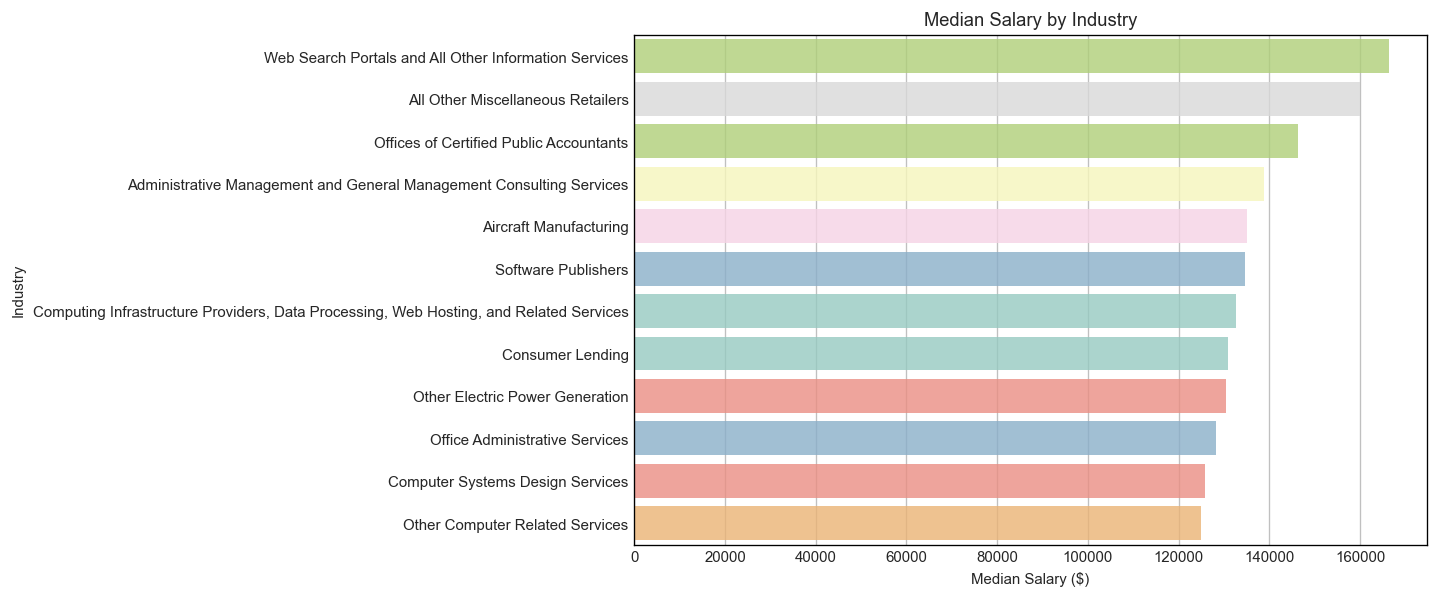

In [240]:
## Plot: Analyze Median Salary by Industry (Seaborn)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# group by industry name and calculate median salary, sort by descending order
top_industry_salary_order = (
    df_jp_2024.groupby("NAICS_2022_6_NAME")["SALARY"]
    .median()
    .sort_values(ascending=False)
    .head(12)
)
industry_order = top_industry_salary_order.index.tolist()

plt.figure(figsize=(12, 5))
ax1=sns.barplot(
    data=df_jp_2024,
    y="NAICS_2022_6_NAME",
    x="SALARY",
    hue="NAICS_2022_6_NAME",
    order=industry_order,
    orient='h',
    palette="Set3",
    estimator=np.median,
    errorbar=None,
    legend=False,
    alpha=0.8
)

for patch in ax1.patches:
    patch.set_alpha(0.8)

plt.title("Median Salary by Industry")
plt.xlabel("Median Salary ($)")
plt.ylabel("Industry")
plt.yticks(ha="right", fontsize=9)
plt.xticks(fontsize=9)
plt.tight_layout()
out_path = "figures/median_salary_by_industry.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

/var/folders/y1/rx8hx7116f35w_wcxbtlb5m80000gn/T/ipykernel_87598/1949499346.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




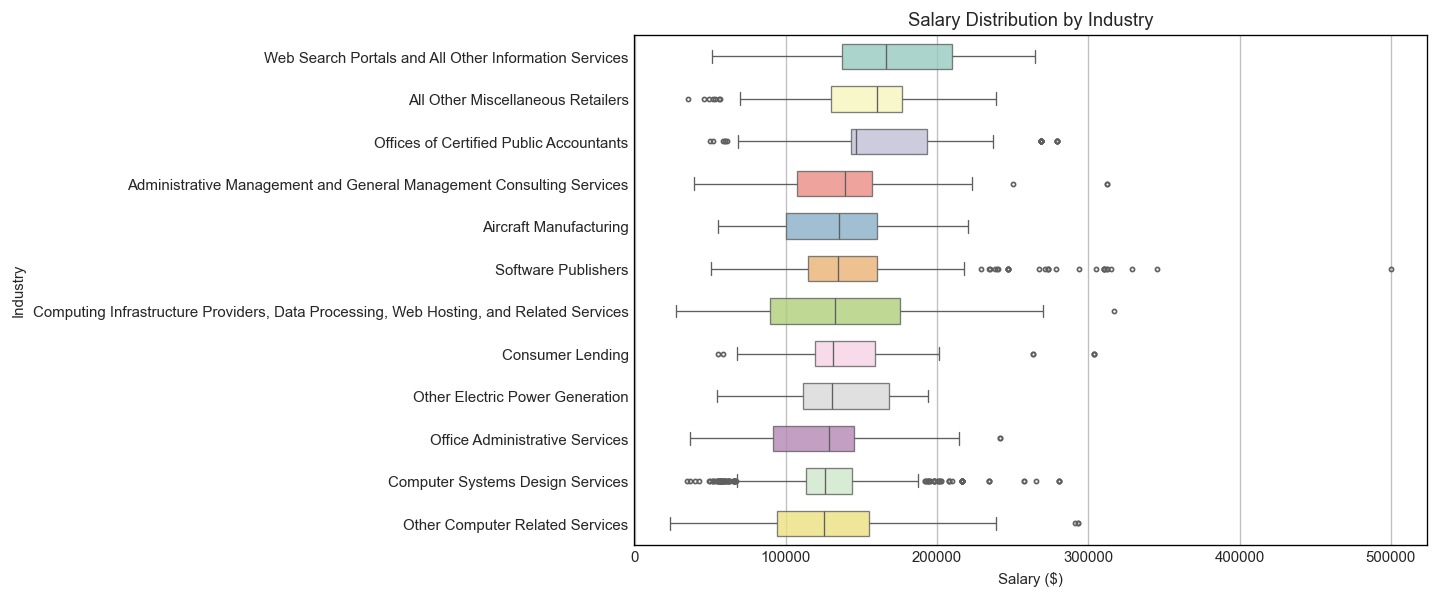

In [241]:
## Plot: Analyze Salary Distribution by Industry (Seaborn)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# # determine IQRs by industry:
# q25 = df_jp_2024.groupby("NAICS_2022_6_NAME")["SALARY"].quantile(0.25)
# q75 = df_jp_2024.groupby("NAICS_2022_6_NAME")["SALARY"].quantile(0.75)
# # sort by the middle 50% (Q3 - Q1) and name that as the new sorting order
# iqr = (q75 - q25).sort_values(ascending=False).head(12)

#iqr_order = iqr.index.to_list()
industry_order = top_industry_salary_order.index.tolist()

plt.figure(figsize=(12, 5))
ax2 = sns.boxplot(
    data=df_jp_2024,
    y="NAICS_2022_6_NAME",
    x="SALARY",
    order=industry_order,
    palette="Set3",
    width=0.6,
    fliersize=2.5,  
    linewidth=0.8,
)

for patch in ax2.patches:
    patch.set_alpha(0.8)

plt.title("Salary Distribution by Industry")
plt.xlabel("Salary ($)")
plt.ylabel("Industry")
plt.yticks(ha="right", fontsize=9)
plt.xticks(fontsize=9)
plt.tight_layout()

# Save and display the figure
out_path = "figures/salary_distribution_by_industry.png"
plt.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

#### 5.1.4 AI vs. Non-AI Job Salary Comparison

In [226]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Create a lowercase version of the BODY column for keyword searching
df["BODY"] = df["BODY"].astype(str).str.lower()

# identify AI related keywords 
ai_keywords = [
    "machine learn",  # matches 'machine learning', 'machine learner'
    "data scien",     # matches 'data scientist', 'data science'
    "artificial intel",  # matches 'artificial intelligence'
    "deep learn",  
    "ml engineer",            
    "data engineer",
    "computer vision", 
    "natural language", 
    "nlp",
    "big data",
    "cloud data"
]

# Create a regex pattern that matches any of the keywords, case-insensitive
ai_pattern = re.compile(r"|".join([re.escape(k) for k in ai_keywords]), flags=re.IGNORECASE)

# Assign a new column is_ai_job to label job postings with AI or Non-AI based on keyword presence in the BODY text
df["is_ai_job"] = df["BODY"].apply(lambda text: "AI" if ai_pattern.search(text) else "Non-AI")

# Filter out rows with null or zero salary and outliers 
df_filtered_1 = df[
    (df["SALARY"].notnull()) &
    (df["SALARY"] > 0)
]
q1 = df_filtered_1["SALARY"].quantile(0.01)
q99 = df_filtered_1["SALARY"].quantile(0.99)
df_filtered_1 = df_filtered_1[(df_filtered_1["SALARY"] >= q1) & (df_filtered_1["SALARY"] <= q99)]

print(df_filtered_1["is_ai_job"].value_counts())


is_ai_job
Non-AI    15948
AI         5273
Name: count, dtype: int64


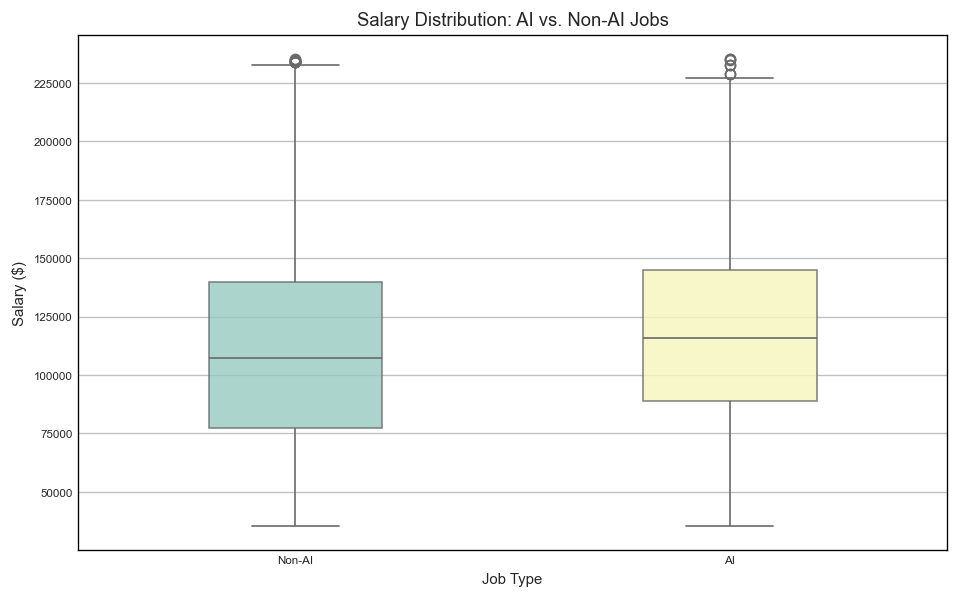

<Figure size 768x576 with 0 Axes>

In [227]:
plt.figure(figsize=(8, 5))
ax3=sns.boxplot(
    data=df_filtered_1, 
    x="is_ai_job", 
    y="SALARY",
    hue="is_ai_job",
    legend=False,
    palette="Set3",
    width=0.4
)

for patch in ax3.patches:
    patch.set_alpha(0.8)

plt.title("Salary Distribution: AI vs. Non-AI Jobs")
plt.xlabel("Job Type", fontsize=9)
plt.ylabel("Salary ($)", fontsize=9)
plt.tight_layout()
plt.show()
out_path = "figures/AI_v_nonAI_salary_boxplot.png"
plt.savefig(out_path, dpi=150)

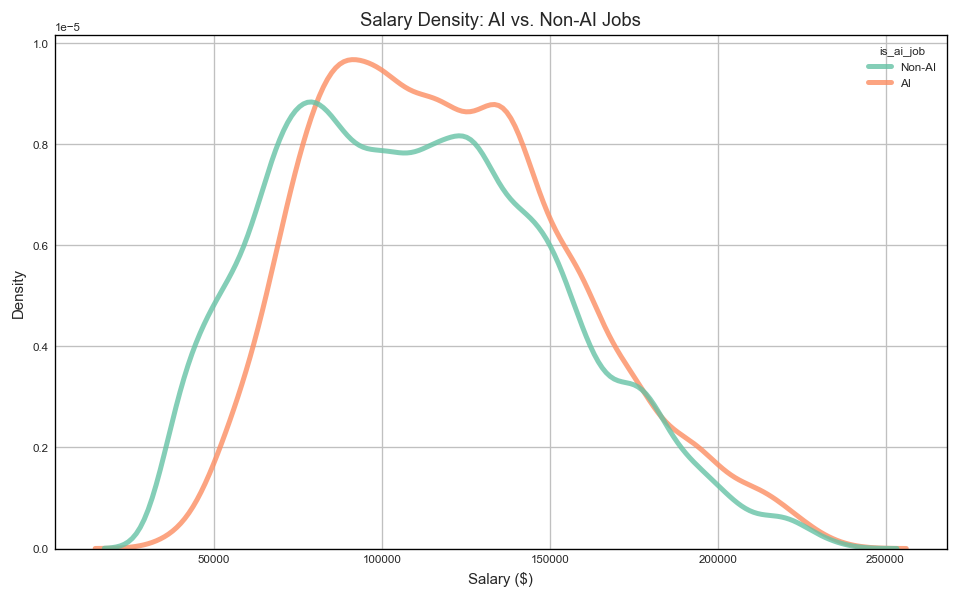

<Figure size 768x576 with 0 Axes>

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns

# KDE Plot
plt.figure(figsize=(8, 5))
ax4=sns.kdeplot(
    data=df_filtered_1, 
    x="SALARY", 
    hue="is_ai_job", 
    common_norm=False,
    linewidth=3,
    palette="Set2",
    alpha=0.8
)

for patch in ax4.patches:
    patch.set_alpha(0.8)

plt.title("Salary Density: AI vs. Non-AI Jobs")
plt.xlabel("Salary ($)", fontsize=9)
plt.ylabel("Density", fontsize=9)
plt.tight_layout()
plt.show()
out_path = "figures/AI_v_nonAI_salary_KDE.png"
plt.savefig(out_path, dpi=150)

### code block for skill_gap_analysis.qmd: 
#### Team-based Skill Dataframe

In [ ]:
# Create list of relevant analytics skills and rate each member from 1-5
import pandas as pd

skills_data = {
    "Name": ["Angelina", "Devin", "Leo"],
    "Python": [3, 1, 3],
    "SQL": [3, 3, 3],
    "Power BI": [5, 4, 4],
    "Tableau": [4, 3, 2],
    "Excel": [5, 5, 4],
    "Machine Learning": [2, 1, 1],
    "NLP": [2, 1, 1],
    "Cloud Computing": [1, 2, 1],
    "AWS": [1, 1, 1]
}

# Convert to dataframe 
df_skills = pd.DataFrame(skills_data)
df_skills.set_index("Name", inplace=True)
df_skills

# Plot df as a heatmap to visualize skill distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_skills, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Team Skill Levels Heatmap")
plt.show()

#### Compare team skills to industry requirements
#### NLP Processing Code Block

In [ ]:
# ## Extract most in-demand skills from JD 

# import pandas as pd
# import re
# from collections import Counter
# from nltk.corpus import stopwords
# from pathlib import Path
# import nltk

# nltk.data.path.append(str(Path.home() / "nltk_data"))

# stop_words = stopwords.words("english")

# # Pull description from job postings and convert into strings
# job_descriptions = df["BODY"].dropna().astype(str).tolist()

# ## NLP processing
# # Combine all JD strings into one string and convert all to lowercase 
# print("Combining job descriptions...")
# all_text = " ".join(job_descriptions).lower()

# # Extract only alphabetical and excludes punctuation, numeric values, symbols (Tokenizing)
# print("Running regex to extract words...")
# words = re.findall(r'\b[a-zA]+\b', all_text)

# # Filter to remove common stopwords 
# print("Filtering out stopwords...")
# words_filtered = [word for word in words if word not in stopwords.words("english")]

# # Count the frequency of each word
# print("Counting word frequencies...")
# words_count = Counter(words_filtered)

# # Define a list of skills: 
# skills_list = {"python", "sql", "aws", "docker", "tableau", "excel", "pandas", "numpy", "power", "spark", "machine", "learning", "nlp", "cloud", "computing"}

# # Extract the predefined skills that actually appear in the job postings text blob; 
# skills_filtered = {
#   skill: words_count[skill]
#   for skill in skills_list
#   if skill in words_count
# }

# print("Top data analytics skills from job description")
# for skill, count in skills_filtered.items():
#   print(f"{skill}:{count}")

#### Compare team skills to industry requirements 2.0
#### OPTIMIZED NLP Processing Code Block

In [ ]:
## Extract most in-demand skills from JD (optimized)

import re
import os
import unicodedata
from collections import Counter

# Import stopwords (Angelina note: switched from NLTK to sklearn's built-in stopwords,
# which avoids downloads and runs faster)
try:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stop_words = set(ENGLISH_STOP_WORDS)
except Exception:
    # Minimal fallback if sklearn is missing
    stop_words = {
        "a","an","and","are","as","at","be","by","for","from","has","he","in","is","it",
        "its","of","on","that","the","to","was","were","will","with"
    }

# Helper function to normalize text
# (Angelina note: ensures Unicode normalized, casefolded, and whitespace trimmed)
def nfc_casefold_trim(s: str) -> str:
    s = unicodedata.normalize("NFC", str(s)).casefold()
    return re.sub(r"\s+", " ", s).strip()

# Compile regex once (Angelina note: faster than re-compiling each loop)
word_re = re.compile(r"[a-z]+")

# Pull description from job postings and count words (streaming, no giant string build)
print("Scanning job descriptions and counting tokens (streaming)...")
words_count = Counter()

for txt in df["BODY"].dropna().astype(str):
    t = nfc_casefold_trim(txt)
    words_count.update(w for w in word_re.findall(t) if w not in stop_words)

# Define a list of skills
skills_list = {
    "python", "sql", "aws", "docker", "tableau", "excel",
    "pandas", "numpy", "spark", "machine", "learning",
    "nlp", "cloud", "computing", "power"
}

# Extract only the predefined skills that appear in job postings
skills_filtered = {s: words_count[s] for s in skills_list if words_count.get(s, 0) > 0}

# Print results, sorted by most frequent
print("Top data analytics skills from job descriptions")
for skill, count in sorted(skills_filtered.items(), key=lambda kv: (-kv[1], kv[0])):
    print(f"{skill}:{count}")


    # --------- added simple bar chart ---------
if skills_filtered:
    os.makedirs("figures", exist_ok=True)  
    items = sorted(skills_filtered.items(), key=lambda kv: kv[1], reverse=True)
    labels = [k for k, _ in items]
    values = [v for _, v in items]

    plt.figure(figsize=(8, 4.5))
    plt.bar(labels, values)
    plt.title("Most In-Demand Skills from Job Descriptions")
    plt.xlabel("Skill")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    out_path = "figures/jd_top_skills.png"
    plt.savefig(out_path, dpi=150)
    plt.show()
    print(f"[Saved chart] {out_path}")


### 3.1.3 Propose an Improvement Plan
Job postings show high demand for Cloud, SQL, Python, ML, and AWS. Our team is strong in visualization (Excel, Power BI, Tableau) but weaker in Cloud, ML, and NLP. This plan aligns our learning with market needs, provides specific resources, and ensures collaboration strategies so the whole team can close the gap together.


**Which skills should each member prioritize learning?**

- **Angelina** – Strong in visualization tools (Power BI 5, Tableau 4, Excel 5). Next priorities: Cloud, AWS, Machine Learning, and NLP. These are high-demand in job postings (Cloud: 64k+, AWS: 10k+, ML/NLP combined: 23k+).  
- **Devin** – Solid in Excel (5) and Tableau (3), but weakest in Python, ML, NLP, and AWS. Needs to raise Cloud as well.  
- **Leo** – Stronger in Power BI (4) and Excel (4), but very low in ML, NLP, Cloud, and AWS. Should also build up Python and SQL to meet market demand (Python: 17k+, SQL: 43k+ mentions).  


**What courses or resources can help?**

- Cloud & AWS – free cloud provider tutorials, AWS Educate, and cloud labs for hands-on practice.  
- Machine Learning & NLP – scikit-learn tutorials, Kaggle competitions, and university modules on ML/NLP.  
- Python & SQL – interactive platforms (Jupyter notebooks, LeetCode SQL), and official documentation.  
- Docker & Spark – short online workshops, Spark quickstarts, and Docker “getting started” labs.  


**How can the team collaborate to bridge skill gaps?**

- **Role rotation:** assign rotating leads (“cloud lead,” “ML/NLP lead,” “Python/SQL lead”) for mini-projects so each teammate practices outside their strengths.  
- **Lightning talks:** weekly 15-minute sessions where one teammate teaches a concept or tool they just learned.  
- **Pair programming:** match stronger members (for example, Angelina for visualization) with weaker ones (for example, Devin on Python) to share knowledge in real time.  
- Shared resources: maintain a team wiki with reusable queries, cloud setup notes, and code snippets.  




# MODULE 4: 1 Regression, Classification, and Topic Insights

## KMeans Clustering Analysis

We performed KMeans clustering on job postings using core features (salary, minimum and maximum years of experience). This analysis seeks to segment jobs into groups with similar compensation and experience profiles, and to interpret these clusters using industry categories (NAICS).


### Fit KMeans and Assign Clusters - Data Prep

We use KMeans clustering to segment jobs into five groups, using standardized salary and experience as inputs. Each posting is assigned to a cluster.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
cluster_features = ['SALARY', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE']
X = df[cluster_features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.cluster import KMeans

# Fit KMeans model
n_clusters = 5  # Assignment recommends 5, we must justify if we change
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df.loc[X.index, 'KMEANS_CLUSTER'] = clusters

In [ ]:
# Checking column names - Angelina (can delete later)
print("ALL COLUMNS:\n", list(df.columns))

print("\nLikely industry/classification columns I see:")
print([c for c in df.columns if any(k in c.upper() for k in ["NAICS","SOC","ONET","INDUSTRY","TITLE"])])

print("\nLikely cluster columns I see:")
print([c for c in df.columns if "CLUSTER" in c.upper() or "KMEANS" in c.upper()])

In [ ]:
# === Create a label column from the trained KMeans model ===
try:
    df["kmeans_labels"] = kmeans.labels_
except AttributeError:
    # if you used fit_predict above, this line already made the column
    if "kmeans_labels" not in df.columns:
        df["kmeans_labels"] = kmeans.fit_predict(X_scaled)

print("✅ KMeans labels column ready:", "kmeans_labels" in df.columns)
print("Unique clusters:", df["kmeans_labels"].nunique())

In [ ]:
# === KMeans Cluster Reference Label Analysis ===
cluster_col = "kmeans_labels"        
label_col   = "NAICS_2022_6_NAME"    # required 'reference label' for interpretation

crosstab = (
    df.groupby([cluster_col, label_col])
      .size()
      .reset_index(name="count")
      .sort_values([cluster_col, "count"], ascending=[True, False])
)
display(crosstab.head(50))

# Most common label per cluster
top_per_cluster = crosstab.loc[crosstab.groupby(cluster_col)["count"].idxmax()].reset_index(drop=True)
print("\nMost common label per cluster:")
display(top_per_cluster)

# Percent share per cluster
ct_share = (
    crosstab
    .join(crosstab.groupby(cluster_col)["count"].transform("sum").rename("cluster_total"))
    .assign(share=lambda d: (d["count"] / d["cluster_total"]).round(3))
    .sort_values([cluster_col, "share"], ascending=[True, False])
)
display(ct_share.head(50))

In [ ]:
# KMeans Cluster Visualization with Top Job Titles
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- SCATTERPLOT OF KMEANS CLUSTERS ---

plot_sample = df.loc[X.index].sample(n=5000, random_state=42) if len(X) > 5000 else df.loc[X.index]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=plot_sample,
    x='SALARY',
    y='MIN_YEARS_EXPERIENCE',
    hue='KMEANS_CLUSTER',
    palette='tab10'
)
plt.title('KMeans Clusters by Salary and Min Years Experience')
plt.xlabel('Salary')
plt.ylabel('Minimum Years Experience')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# --- TOP 5 JOB TITLES PER CLUSTER ---

print("Top 5 Job Titles for Each Cluster:\n")
for cluster in sorted(df['KMEANS_CLUSTER'].dropna().unique()):
    print(f"\nCluster {int(cluster)}:")
    print(df[df['KMEANS_CLUSTER'] == cluster]['TITLE_CLEAN'].value_counts().head(5))

### Top 5 Job Titles for Each Cluster

**Cluster 0:**  
- data analyst — 3,009  
- senior data analyst — 627  
- business intelligence analyst — 501  
- enterprise architect — 389  
- unlock your future career path in data analytics — 238  

**Cluster 1:**  
- enterprise architect cleared — 71  
- senior data analyst navista — 50  
- sr data analyst strategy and business intelligence — 40  
- security senior solution architect — 33  
- data analyst — 32  

**Cluster 2:**  
- enterprise architect — 319  
- erp senior business analyst fp a — 197  
- data analyst — 132  
- zero trust architect — 89  
- senior data analyst — 69  

**Cluster 3:**  
- data analyst — 1,386  
- business intelligence analyst — 220  
- data and reporting professional — 100  
- retail data analyst — 81  
- part sales data analyst — 59  

**Cluster 4:**  
- data engineer analytics — 117  
- enterprise architect — 105  
- oracle hcm cloud manager — 87  
- sap functional implementation lead payroll module — 58  
- data engineer analytics technical leadership — 57  


#### Figure: Top 5 Job Titles per Cluster

In [ ]:
# --- Bar chart for the top 5 titles in Cluster 0 (change cluster_num as needed) ---

cluster_num = 0
top_titles = df[df['KMEANS_CLUSTER'] == cluster_num]['TITLE_CLEAN'].value_counts().head(5)

plt.figure(figsize=(8, 5))
bars = top_titles.plot(kind='bar', color='skyblue')
plt.title(f'Top 5 Job Titles in Cluster {cluster_num}')
plt.xlabel('Job Title')
plt.ylabel('Count')

# Add the counts on top of the bars
for idx, value in enumerate(top_titles.values):
    plt.text(idx, value + max(top_titles.values)*0.01, str(value), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

**Figure:** Top 5 Job Titles per Cluster

#### Analysis for Business Relevance

The clusters reveal how salary and experience interact across industries. When linked with NAICS reference codes, lower-salary clusters correspond primarily to administrative support and retail services, while higher-salary clusters (1, 2, 4) align with technology, finance, and professional-services sectors. This pattern confirms that advanced technical and analytical roles command higher compensation even at similar experience levels.

**For job seekers**, understanding which industries occupy higher clusters can guide upskilling toward data engineering, cloud, or analytics leadership roles that return stronger salary growth.

**For employers**, these clusters act as market benchmarks, helping calibrate compensation and experience requirements to remain competitive in high-demand technical fields.


In [ ]:
# Cross-tab clusters by industry to interpret groupings
crosstab = pd.crosstab(
    df.loc[X.index, 'KMEANS_CLUSTER'],
    df.loc[X.index, 'NAICS_2022_6_NAME']
)
crosstab

**Figure:** KMeans clusters for job postings, plotted by salary and minimum years experience.

## Regression – Predicting Salary

We chose Random Forest over Linear Regression because the relationship between experience and salary is non-linear, and the model captures complex interactions more effectively.

The goal of this model is to predict job posting salary using experience and employment type features. The model uses an 80/20 train–test split and evaluates performance using RMSE and R² metrics.


In [ ]:
# Feature Selection and Data Preparation
from sklearn.model_selection import train_test_split
import pandas as pd

# Use minimum years of experience, maximum years of experience, and employment type as features
features = ['MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE', 'EMPLOYMENT_TYPE_NAME']

# One-hot encode employment type
df_encoded = pd.get_dummies(df, columns=['EMPLOYMENT_TYPE_NAME'], drop_first=True)

X = df_encoded[[col for col in df_encoded.columns if col in features or col.startswith('EMPLOYMENT_TYPE_NAME_')]]
y = df_encoded['SALARY']

X = X.dropna()
y = y.loc[X.index]

# Train/test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train a random forest regression model to predict salary
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict salaries for the test set
y_pred = rf.predict(X_test)

# Calculate RMSE (Root Mean Squared Error) and R² (coefficient of determination)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R² Score: {r2:.3f}')

In [ ]:
# Visual: Predicted vs. Actual Salary
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Predicted vs. Actual Salary (Random Forest Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.legend()
plt.tight_layout()
plt.show()

**Figure:** Predicted vs. actual salaries from the regression model. Points closer to the red dashed line indicate more accurate predictions.

In [ ]:
# Feature importance: shows which variables most influence salary prediction
importances = rf.feature_importances_
feature_names = X.columns

feat_imp = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)
print("Top 5 features influencing salary prediction:")
for name, imp in feat_imp[:5]:
    print(f"{name}: {imp:.3f}")

In [ ]:
# Visual: Feature Importance Bar Chart
import pandas as pd

feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False).head(5)

plt.figure(figsize=(8, 5))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 5 Feature Importances (Random Forest Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Figure:** Top 5 features influencing salary predictions, as measured by the random forest model.

In [ ]:
# Calculate absolute prediction error for each job
errors = np.abs(y_test - y_pred)
outlier_indices = errors.sort_values(ascending=False).head(5).index

# Show the original job posting rows for these outliers
print(df.loc[outlier_indices][['SALARY', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE', 'EMPLOYMENT_TYPE_NAME']])

In [ ]:
# Visual: Highlight Outliers in Predicted vs. Actual Salary

labels = [
    f"${int(sal):,}\n{min_exp}yr min\n{emp_type}" 
    for sal, min_exp, emp_type in zip(
        df.loc[outlier_indices]['SALARY'], 
        df.loc[outlier_indices]['MIN_YEARS_EXPERIENCE'], 
        df.loc[outlier_indices]['EMPLOYMENT_TYPE_NAME']
    )
]

plt.figure(figsize=(10, 5))
plt.bar(labels, df.loc[outlier_indices]['SALARY'], color='tomato')
plt.ylabel("Actual Salary")
plt.title("Top 5 Outlier Job Salaries")
plt.tight_layout()
plt.show()

**Figure:** Actual salaries of the five largest outlier jobs. Job experience and employment type are shown in labels.

**Outlier Analysis**

A review of the top 5 largest prediction errors shows several jobs with extremely high actual salaries (all above \$300,000), yet typical or even low minimum/maximum years of experience, and standard employment types. Examples include:

| Actual Salary | Min Experience | Max Experience | Employment Type          |
|---------------|---------------|----------------|-------------------------|
| $470,000      | 5             | 3              | Full-time (> 32 hours)  |
| $437,500      | 15            | 3              | Full-time (> 32 hours)  |
| $347,075      | 5             | 3              | Part-time / full-time   |
| $353,500      | 8             | 3              | Full-time (> 32 hours)  |
| $328,600      | 5             | 3              | Full-time (> 32 hours)  |

These outlier jobs may represent rare executive roles, data entry issues, or atypical salary reporting.  
Their presence skews the model’s RMSE and makes prediction more difficult. In a business context, further investigation or filtering of these outliers would improve overall model accuracy and provide more relevant insights for most job seekers.

#### Regression Results and Interpretation

A random forest regression model was trained to predict salary using minimum years of experience, maximum years of experience, and employment type as features. The model was evaluated with a 70/30 train-test split.

- **Root Mean Squared Error (RMSE):** 27,598.44
- **R² Score:** 0.115

The R² score shows that a limited amount of salary variation is explained by these features, indicating that other factors (not included in the model) may also influence salary.

**Top features influencing salary prediction:**
1. Minimum years of experience (0.910)
2. Employment type: Part-time (≤ 32 hours) (0.044)
3. Maximum years of experience (0.029)
4. Employment type: Part-time / full-time (0.016)
5. Employment type: Unknown (0.000)

**Interpretation for business and job-seeker implications:**
- **Minimum years of experience** is the strongest driver of salary in this dataset.
- **Employment type** and **maximum years of experience** also play a smaller role.
- Job seekers should highlight their relevant experience to increase their salary potential.
- Employers should consider how clearly defined experience requirements and employment types may impact pay and candidate attraction.

**Note on outliers:**  
Several extreme outliers (very high salaries with typical experience and standard employment types) were found. These can affect the model's accuracy and may reflect unusual roles, reporting issues, or data entry errors. In a real business scenario, further investigation or filtering of these outliers would be recommended to improve model reliability.

## Classification – Predicting Remote vs On-Site Job

In [ ]:
# Classification: Predicting Remote vs On-Site Jobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Prepare data
clf_df = df[["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME", "REMOTE_TYPE_NAME"]].dropna().copy()
clf_df["IS_REMOTE"] = clf_df["REMOTE_TYPE_NAME"].str.contains("Remote", case=False).astype(int)

X = clf_df[["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE", "EMPLOYMENT_TYPE_NAME"]]
y = clf_df["IS_REMOTE"]

# One-hot encode employment type
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["EMPLOYMENT_TYPE_NAME"]),
    ("num", "passthrough", ["MIN_YEARS_EXPERIENCE", "MAX_YEARS_EXPERIENCE"])
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Model
clf = Pipeline([
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight='balanced'))
])
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Metrics
acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
print(f"Accuracy: {acc:.3f}, F1 Score: {f1:.3f}")

# Confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(cmap="Blues")
plt.title("Confusion Matrix — Remote vs On-Site Classification")
plt.show()


### Classification Results and Interpretation

We trained a logistic-regression model to predict whether a job posting is remote or on-site using years of experience and employment type.
After applying class_weight='balanced' to handle class imbalance, model performance reached Accuracy ≈ 0.60 and F1 ≈ 0.29.

The confusion matrix shows that while most on-site roles are correctly detected, roughly one-third of remote jobs are now correctly identified.
These results suggest that experience level and employment type provide some predictive power, but additional features such as job title, industry, or skills would likely improve remote-work detection.

## Conclusive Key Insights and Recommendations for Job Seekers

- **Industry segmentation (KMeans)** shows distinct clusters by salary and experience; tech and professional-services roles dominate higher-pay clusters.  
- **Salary modeling (Regression)** confirms that years of experience and job type drive pay levels.  
- **Remote-work classification** indicates that higher experience and full-time roles increase the likelihood of remote opportunities.  
- **Implication:** Job seekers should focus on building experience and targeting high-skill industries to improve salary potential and remote flexibility.
